**Class 4: Deep Q Networks.**

1. <a href="#sec1">Environments</a>
    1. <a href="#sec1.1">Cartpole</a>
    2. <a href="#sec1.2">Cartpole swing-up</a>
    3. <a href="#sec1.3">Pong</a>
2. <a href="#sec2">Value Iteration as a sequence of Supervized Learning problems</a>
3. <a href="#sec3">Experience Replay</a>
4. <a href="#sec4">A deep Q-network</a>
5. <a href="#sec5">Making DQN more efficient</a>
    1. <a href="#sec5.1">Target network</a>
    2. <a href="#sec5.2">Error clipping</a>
6. <a href="#sec6">DQN on image-based tasks</a>
7. <a href="#sec7">Going further</a>

Let's start with this quote:

> The idea that we learn by interacting with our environment is probably the first to occur to us when we think about the nature of learning. When an infant plays, waves its arms, or looks about, it has no explicit teacher, but it does have a direct sensorimotor connection to its environment. Exercising this connection produces a wealth of information about cause and effect, about the consequences of actions, and about what to do in order to achieve goals. Throughout our lives, such interactions are undoubtedly a major source of knowledge about our environment and ourselves. Whether we are learning to drive a car or to hold a conversation, we are acutely aware of how our environment responds to what we do, and we seek to influence what happens through our behavior. Learning from interaction is a foundational idea underlying nearly all theories of learning and intelligence. (Richard S. Sutton)

# <a id=sec1></a> Environments

In this session, we will work with three different environments:
- CartPole
- A modified version of CartPole
- Pong

In [29]:
import gym
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
gym.logger.set_level(gym.logger.DISABLED)

import torch.nn as nn
import torch.nn.functional as F

## <a id=sec1.1></a>CartPole

In [2]:
cartpole = gym.make('CartPole-v1')

From the [OpenAI Gym website](https://gym.openai.com/envs/CartPole-v0/)

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [3]:
print(cartpole.action_space)
print(cartpole.observation_space)
print(cartpole.env.metadata)

Discrete(2)
Box(4,)
{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}


In [9]:
x = cartpole.reset()
cartpole.render()
for i in range(1000):
    _,_,d,_ = cartpole.step(np.random.randint(2))
    cartpole.render()
    if d:
        print(i)
        break
cartpole.close()

9


## <a id=sec1.2></a>CartPole Swing-up

The idea here is to keep the same environment, but instead of learning how to stabilize it around the unstable equilibrium point, we'd like to learn to swing it up. Here are the changes:
- `reset` now puts the pole pointing down. The initial state is $(0,0,\pi,0)$ plus a vector of four uniformly random values in [-0.05,0.05].
- `step` now returns `done=True` when the cart leaves the $x\in [-2.4,2.4]$ interval or when the pole swings faster than $4\pi$ radians per second.
- the reward is still +1 for keeping the pole within 12 degrees of the vertical, it is 0 for all other time steps and -10 for swinging too fast or exiting the screen.

In [10]:
class CartPoleSwingUp(gym.Wrapper):
    def __init__(self, env, **kwargs):
        super(CartPoleSwingUp, self).__init__(env, **kwargs)
        self.theta_dot_threshold = 4*np.pi
    def reset(self):
        self.state = [0,0,np.pi,0] + super().reset()
        #self.state = [0,0,np.pi,0] + self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)
    def step(self, action):
        state = self.state
        state,reward,done,_ = super().step(action)
        x, x_dot, theta, theta_dot = state
        
        done =  x < -self.x_threshold \
                or x > self.x_threshold \
                or theta_dot < -self.theta_dot_threshold \
                or theta_dot > self.theta_dot_threshold
        done = bool(done)
        
        if done:
            # game over
            reward = -10.
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0
            else:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
        else:
            if theta < -self.theta_threshold_radians \
                or theta > self.theta_threshold_radians:
                # pole upright
                reward = 1.
            else:
                # pole swinging
                reward = 0.

        return np.array(self.state), reward, done, {}

In [11]:
swingup = CartPoleSwingUp(gym.make('CartPole-v1'))

In [14]:
x = swingup.reset()
swingup.render()
for i in range(1000):
    _,_,d,_ = swingup.step(np.random.randint(2))
    swingup.render()
    if d:
        print(i)
        break
swingup.close()

300


## <a id=sec1.3></a>Pong

Let's build an agent that learns to play Pong, one of the [Atari games](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py) in Gym (originally in the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)). You might want to try different games later on (like the popular Breakout game for instance).

In [15]:
pong = gym.make('Pong-v4')

Here is the environment's description.
> Maximize your score in the Atari 2600 game Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from $\{2, 3, 4\}$.

In [16]:
print(pong.observation_space)
print(pong.observation_space.shape)
print(np.min(pong.observation_space.low))
print(np.max(pong.observation_space.high))
print(pong.action_space)
#help(env.observation_space)

Box(210, 160, 3)
(210, 160, 3)
0
255
Discrete(6)


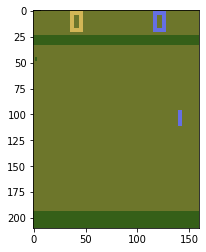

In [19]:
x = pong.reset()
plt.imshow(x)
plt.show()

<div class="alert alert-warning">

**Exercice:** What is the number of possible states? Why is this not an MDP? What would one need to turn this back into an MDP?
</div>

<div class="alert alert-danger">

**Solution:**

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

This is not an MDP because the transition dynamics do not respect Markov's property. The probability of transitioning from $s_t$ to $s_{t+1}$ is *not* independent of previous states. The problem here is that a single frame of the game does not reflect the velocity of the ball.

To recover Markov's property one could simply stack a few frames together in the state space.
</div>

There are 18 buttons on the Atari controller. However not all games use all buttons. Our interface to Pong specifies 6 possible actions:
- 0 NOOP (no operation)
- 1 FIRE (press fire button, doesn't do anything in Pong)
- 2 RIGHT (actually moves the paddle up in Pong)
- 3 LEFT (actually moves the paddle left in Pong)
- 4 UP (moves the paddle upwards)
- 5 DOWN (moves the paddle downwards)

It goes up to the 6th action for naming consistency (UP and DOWN), because the other actions are not really useful.

Also, for an unknown reason, the game does not start until the 20th frame (but always starts automatically, pressing FIRE does not change anything).

The frame rate is 60Hz.

To avoid confusion between the 6 actions allowed by Gym, let's build a wrapper around our environment, with only 2 possible actions ("0" for UP and "1" for DOWN) and a downscaled observation space. Unless you're curious and want to dig in the code, you can simply run the following cells and just use the resulting environment.

In [20]:
from gym.wrappers import AtariPreprocessing
import cv2

class PongWrapper(AtariPreprocessing):
    def __init__(self, env, **kwargs):
        super(PongWrapper, self).__init__(env, **kwargs)
    def step(self,action):
        return super(PongWrapper, self).step(4+action)
    def _get_obs(self):
        if self.frame_skip > 1:  # more efficient in-place pooling
            np.maximum(self.obs_buffer[0], self.obs_buffer[1], out=self.obs_buffer[0])
        obs = cv2.resize(self.obs_buffer[0], (84, 110), interpolation=cv2.INTER_AREA)[17:101,:]

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        else:
            obs = np.asarray(obs, dtype=np.uint8)
        return obs

In [21]:
pong = PongWrapper(gym.make('PongNoFrameskip-v4'),
                   noop_max=0,
                   frame_skip=4,
                   terminal_on_life_loss=True,
                   grayscale_obs=True,
                   scale_obs=True)

shape: (84, 84), min = 0.34117648, max = 0.9137255, dtype = float32


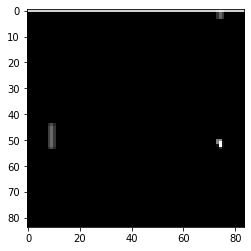

In [23]:
# Trying a random agent in Pong
import time

pong.reset()
pong.render()
for i in range(60):
    a = np.random.randint(2)
    x,r,_,_=pong.step(a)
    pong.render()
    #print('\r', "reward", r, end="")
    time.sleep(0.1)
    
pong.close()
print("shape: ", x.shape, ", min = ", x.min(), ", max = ", x.max(), ", dtype = ", x.dtype, sep='')
plt.imshow(x, cmap='gray');

# <a id=sec2></a>Value Iteration as a sequence of Supervized Learning problems

<div class="alert alert-warning">

**Exercice:** start from the Value Iteration update and write $Q_{n+1}$ as a regression problem with parameters $\theta_{n+1}$. Specify the loss function minimized for this regression problem.
</div>

<div class="alert alert-danger">

**Solution:**

Let's start over from the beginning. We want to find:
$$\pi^*(s) = \arg\max_{\pi} \mathbb{E}_{\left(r_t\right)_{t\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r_t \ \Big| \ s, \pi \right], \ \forall s\in S.$$

We have seen this was equivalent to finding the optimal value function $Q^*$:
$$Q^*(s,a) = \max_{\pi} \mathbb{E}_{\left(r_t\right)_{t\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r_t \ \Big| \  s,a, \pi \right], \ \forall (s,a) \in S\times A.$$

And we have established that $Q^*$ was the only solution to Bellman's optimality equation:
$$Q(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a')\right].$$

By writing $T^*$ Bellman's optimality operator, we have, by definition:
$$(T^*Q)(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a')\right].$$

And thus, $Q^*$ is the only solution to $Q=T^*Q$.

It appears $T^*$ is a contraction mapping on the $\mathcal{F}(S\times A,\mathbb{R})$ space. Value Iteration exploits this property to build the sequence $Q_{n+1} = T^*Q_n$ which converges to $Q^*$.

Let's now suppose that $Q_n$ is a function approximator, whose parameters are $\theta_n$. We shall write $Q_n(s,a) = Q(s,a;\theta_n)$. Then building $\theta_{n+1}$ knowing $\theta_n$ is the regression problem that minimizes the loss:
\begin{gather}
L_n(\theta) = \left\| y(s,a) - Q(s,a;\theta) \right\|,\\
\textrm{with } y(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right].
\end{gather}

If this loss can be optimized and goes to zero, then we have found the true $Q_{n+1}$. If not, then we have found an approximation of it in the norm used to define $L_n$.

</div>

<div class="alert alert-warning">

**Exercice:** use the L2 norm in the loss of the regression problem above, then write the gradient of the loss with respect to the regressor's parameters. Use this to introduce a stochastic gradient descent method to find $\theta_{n+1}$.
</div>

<div class="alert alert-danger">

**Solution:**

Our loss becomes:
\begin{gather}
L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \big( y(s,a) - Q(s,a;\theta) \big)^2 \right],\\
\textrm{with } y(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right].
\end{gather}

In the expression above, $\rho$ is a distribution over the state-action space. Often, it is considered to be the behavior distribution, that is the distribution of samples under the current behavior policy, like $\epsilon$-greedy. Note that this choice is debatable.

So the gradient of this loss is:
\begin{gather}
\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \big( y(s,a) - Q(s,a;\theta) \big) \nabla_\theta Q(s,a;\theta) \right]\\
\textrm{with } y(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right].
\end{gather}

And when we wrap all this together:
$$\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \left( \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right] - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

$$\nabla_\theta L_n(\theta) = \mathbb{E}_{\substack{(s,a) \sim \rho(\cdot)\\ s' \sim p(\cdot|s,a)}}\left[ \left( r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n}) - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

Rather than computing the full expectations in the above gradient, it is often computationally expedient to optimise the loss function by stochastic gradient descent. Then the stochastic estimate of the gradient is given by:
$$\nabla_\theta L_n(\theta) \approx d_n(\theta) = \sum_{i=1}^B \left[ \left( r_i + \gamma \max_{a'} Q(s_i',a',\theta_{n}) - Q(s_i,a_i;\theta) \right) \nabla_\theta Q(s_i,a_i;\theta) \right],$$
where $\left\{ \left(s_i,a_i,r_i,s'_i\right) \right\}_{i\in {1,B}}$ is a mini-batch of samples drawn independently, with $(s,a) \sim \rho(\cdot)$ and $s' \sim p(\cdot | s,a)$.

The stochastic gradient descent procedure builds a sequence of parameter values $\theta_i$ such that:
$$\theta_{i+1} \leftarrow \theta_{i} - \alpha d_n(\theta_{i})$$

By repeating such gradient steps, one progressively minimizes $L_n(\theta)$ and finds $\theta_{n+1}$.

**Important remark:**

In the update above, if the mini-batch contains a single element, the 1-sample update is precisely that of Q-learning! Then, in Q-learning, the new loss $L_{n+1}$ is defined and the process is repeated. Consequently, there is a new loss function at each time step.

<div class="alert alert-warning">

**Exercice:** can you spot the (subtle but essential) difference with Q-learning?
</div>

<div class="alert alert-danger">

**Solution:**

Recall Q-learning. The update was indeed the same, except that at any time step the mini-batch's single element was not sampled independently from the previous minibatch! Indeed, $s'$ from the previous time step becomes $s$ for the current time step. So the successive mini-batches' elements are not drawn iid.

That's a key difference that questions the foundation of Q-learning in itself.
</div>

# <a id=sec3></a>Experience Replay

To recover the independence assumption between samples, we can introduce the mechanism of *Experience Replay* by storing past samples into a *Replay Memory*. When samples a required for a mini-batch gradient update, the samples are collected uniformly from the replay memory, thus mimicking an (almost) independent draw according to $\rho(\cdot)$.

<div class="alert alert-warning">
    
**Exercice:** design a class for the replay memory of the cart-pole example(s). Limit the size of this memory (via a FIFO mechanism) to $10^6$ samples (adapt this number to your computer's RAM). Test it by running a random policy for $2\cdot 10^6$ time steps.
</div>

In [28]:
class ExperienceReplay:
    def __init__(self, memory_size=int(1e6)):
        """ Data structure used to hold game experiences """
        # Memory will contain [state,action,next_state,reward,done]
        self.memory = []
        self.memory_size = memory_size
    
    def add(self, experience):
        """ Adds list of experiences to the memory """
        # Extend the stored experiences
        self.memory.extend(experience)
        # Keep the last memory_size number of experiences
        self.memory = self.memory[-self.memory_size:]
        
    def sample(self, size):
        """ Returns a sample of experiences from the memory """
        sample_idxs = np.random.randint(len(self.memory),size=size)
        sample_output = [self.memory[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output,(size,-1))
        return sample_output

state = cartpole.reset()
exp_replay = ExperienceReplay(memory_size = int(2e6))
# swingup.render()
for i in range(int(2e6)):
    a = np.random.randint(2)
    next_state, r, d, _ = cartpole.step(a)
    exp_replay.add([[state, a, next_state, r, d]])
    state = next_state
#     swingup.render()
# swingup.close()

KeyboardInterrupt: 

# <a id=sec4></a>A deep Q-network

The term Deep Q-Network was coined by the (now historical) paper **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** by Mnih et al. (2013) that put forward the main ideas we develop here. All those were later popularized by DeepMind's paper in Nature **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** by Mnih et al. (2015).

Let's design a (deep) neural network that will serve as a function approximator for $Q(s,a;\theta)$. 

<img src="images/dqlas.png" height="15%" width="15%"></img>

Note that since we're going to have to compute $\max_a Q(s,a)$ it is preferable to avoid running as many passes through the network as there are actions. Therefore, instead of the network structure above, we will prefer to use the one below.

<img src="images/dqls.png" height="30%" width="30%"></img>

<div class="alert alert-warning">
    
**Exercice:** declare a neural network for our Q function. For the CartPole task, you can use a simple network with 2 hidden layers and 16 neurons on each layer. For the SwingUp task, go up to 50 neurons per layer. For Pong... well wait a minute, we'll get to it later.
</div>

In [30]:
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.input_layer = nn.Linear(4, 4)
        self.hidden_1 = nn.Linear(4, 16)
        self.hidden_2 = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.relu(self.output_layer(x))
        return x

We're almost there. Now you can implement the algorithm that:
- takes $\epsilon$-greedy actions with respect to $Q$
- stores samples in the replay buffer
- at each interaction step with the environment, draws a mini-batch, computes the target values for each $(s,a)$ and takes a gradient step.
- repeats

You can take inspiration from the algorithm on page 5 of [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602).

A common optimizer (instead of plain SGD) is RMSprop. But don't run this code just yet!

In [ ]:
# YOUR DEEP Q LEARNING CODE

# <a id=sec5></a>Making DQN more efficient


## <a id=sec5.1></a>Target network
It appears the code above will (probably) slowly converge to $Q^*$ but this convergence might be unstable and noisy. This can be greatly improved by taking several gradient steps on a given loss function $L_n$ instead of changing the loss function at each time step.

In practice, this is achieved by the introduction of a *target network* whose parameters are noted $\theta^-$. This idea was introduced in the [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning) paper. At any time step, the loss becomes:
$$L(\theta) = \mathbb{E}_{s,a,r,s'} \left[ \left( r + \gamma \max_{a'} Q(s',a',\theta^-) - Q(s,a;\theta) \right) ^2 \right],$$
and the target network parameters $\theta^-$ are only updated with the Q-network parameters $\theta_n$ every $C$ steps and are held fixed between individual updates.

This process of accumulating several gradient steps into $\theta_n$ before updating $\theta^-$ draws our algorithm closer to a Value Iteration scheme (or a Fitted Q-Iteration scheme for that matter).

Note that more recent approaches smooth out this accumulation process by defining soft updates of the form:
$$\theta^- \leftarrow \beta \theta^- + (1-\beta) \theta_n.$$

## <a id=sec5.2></a>Error clipping

Another common pratice to stabilize learning is to clip the value of $r + \gamma \max_{a'} Q(s',a',\theta^-) - Q(s,a;\theta)$ between $-1$ and $1$. This is not such an uncommon trick, it actually amounts to using an L2 loss for values of the loss between $-1$ and $1$ and an L1 loss outside of this domain.

<div class="alert alert-warning">
    
**Exercice:** modify you code above to include a target network (with $C$ in the order of $100$) and the clipping of the error term. Then run it to learn an efficient policy for CartPole (then for SwingUp).
</div>

In [ ]:
# YOUR IMPROVED DEEP Q LEARNING CODE

# <a id=sec6></a>DQN on image-based tasks

Now it's time to turn towards Pong. As you noted earlier, the frame information in Pong is not sufficient to define an MDP, but stacking several frames together allows to recover the Markov property.

<div class="alert alert-warning">
    
**Exercice:** modify your replay buffer to store stacks of 4 black-and-white images.
</div>

In [ ]:
# YOUR REPLAY BUFFER FOR PONG

The two DQN papers ([Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602) and [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)) actually introduce two different neural network architectures.

The 2013 paper uses this architecture:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

The 2015 paper 
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 32 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 64 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 2: Convolutions with 64 filters of size $3\times 3$ and stride 1. The activation is a ReLU function.
- layer 3: Fully connected with 512 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

<div class="alert alert-warning">
    
**Exercice:** Create the corresponding neural network and adapt your optimization code from the previous exercice to train on Pong (you can take $C$ much larger, in the order of $10000$).
</div>
Caveat: unless you have a GPU and a fair amount of time ahead of you, it is recommended to run this computation on a cloud computing service (or on a dediated machine).

In [ ]:
# YOUR DQN CODE FOR PONG

To give you an idea of the behavior of a trained agent, you can check the following videos.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("p88R2_3yWPA")

In [ ]:
YouTubeVideo("TmPfTpjtdgg")

# <a id=sec7></a>Going further

A lot of contributions have built on the initial success of DQN. Among those, some are combined and discussed in the **[Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)** paper. We will simply summarize their key ideas here, by decreasing order of importance (according to the paper).

- N-step returns. Use samples that accumulate several returns rather than the 1-step return of TD(0).
- Prioritized experience replay. Inspired by the model-based Prioritized Sweeping approach, bias the distribution used to sample mini-batches in order to present high residual samples to the optimizer. This accelerates the convergence in $L_\infty$ norm.
- Distributional value functions. Instead of estimating $\mathbb{E}(\sum_t r_t)$, estimate the distribution of $\sum_t r_t$ and iterate on it.
- NoisyNet. Instead of an $\epsilon$-greedy exploration strategy, introduce noise in the network's parameters to drive the exploration.
- Dueling architecture. The neural network's architecture splits $Q$ into the estimation of a value $V(s)$ and an advantage $A(s,a)$ with shared first layers.
- Double Q-learning. Q-learning is prone to over-estimation of the true optimal Q function (especially in high variance environments). Double Q-learning aims at compensating this weakness by introducing an under-estimation mechanism based on a second Q function.

Beyond these improvements, new work is published each year that lead to better understanding of the interplay between Deep Learning and RL.